# Projet 1: Analyse de sentiment multi-langue - Deep Learning
### Groupe 4 : Thierno Diallo, Virgile Sassano, Christopher Leccia, Victor Fluchaire

Dans ce projet, notre tâche consiste à construire un modèle capable de classer les sentiments de données textuelles, au moins sur deux niveaux (positif, négatif) et capable de fonctionner à minima sur des textes en anglais et en français.
Nous avons selectionné le jeu de données de Twitter sur Kaggle : Sentiment140 dataset with 1.6 million tweets (https://www.kaggle.com/kazanova/sentiment140)

Pour ce projet nous avons choisi d'utiliser TensorFlow et Keras pour effectuer cette analyse et pour les tests de précision, nous avons utilisé GoogleCollab car nos machines n'avaient pas assez de mémoire pour les faire.

### Chargement des librairies

Retour(s) attendu(s): Aucune erreur et lancement de TensorFlow

In [1]:
import tensorflow.compat.v1 as tf
import json
import numpy as np
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from sklearn.model_selection import KFold
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dropout, Activation
from keras.models import model_from_json

Using TensorFlow backend.


### Chargement du Dataset présent dans le dossier GitHub
Retour(s) attendu(s): Chargement du jeu de données avec les colonnes qui nous intéresse et sans les en-têtes

In [2]:
#r"./twitter_dataset.csv"
training = np.genfromtxt(
    r"./PoC1/Equipe4DeepLearning-virgile-test/Equipe4DeepLearning-virgile-test/testCSV.csv",
    delimiter='",',
    skip_header=1,
    usecols=(0, 5),
    dtype='O',
    max_rows=1000000,
)

### Entrainement de notre modèle
Retour(s) attendu(s): Pas d'erreurs

In [3]:
train_x = [x[1].decode("utf-8") for x in training]
train_y_temp = np.asarray([x[0].decode("utf-8") for x in training])

train_y = []
for y in train_y_temp:
    train_y.append(int(y[1]))

train_y = np.asarray(train_y)

max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_x)

dictionary = tokenizer.word_index
with open("dictionary.json", "w") as dictionary_file:
    json.dump(dictionary, dictionary_file)

In [4]:
# Une chose vraiment importante que fait `text_to_word_sequence` 
# est de faire en sorte que tous les textes aient la même longueur 
def convert_text_to_index_array(text):

    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []

In [5]:
allWordIndices = []

# Pour chaque tweet, changer chaque token pour son ID dans le word_index du Tokenizer
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

# Nous avons maintenant une liste de tous les tweets convertis en tableaux d'index 
# à convertir en tableau pour une utilisation future. 
allWordIndices = np.asarray(allWordIndices)

# Création des matrices uniques à partir des tweets indexés
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode="binary")

# Traitement des étiquettes comme des catégories
train_y = keras.utils.to_categorical(train_y, 2)

 # Modélisation et entrainement
### 1ère Architecture du réseau
Architecture simple avec 3 couches et 770 neurones au total (entrée et sortie inclus). Nous avons mis que 5 Epochs car cela suffisait amplement pour avoir un résultats intéressant. 

In [6]:
model = Sequential(
    [
        keras.layers.Dense(512, input_shape=(max_words,), activation="relu"),
        keras.layers.Dense(256, activation='sigmoid'),
        keras.layers.Dense(2, activation="softmax")
    ]
)


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('modelV1.h5')

Train on 18756 samples, validate on 2085 samples
Epoch 1/5
18756/18756 [==============================] - 12s 665us/step - loss: 0.4994 - accuracy: 0.7558 - val_loss: 0.3207 - val_accuracy: 0.8868
Epoch 2/5
18756/18756 [==============================] - 12s 645us/step - loss: 0.2713 - accuracy: 0.8897 - val_loss: 0.7356 - val_accuracy: 0.6916
Epoch 3/5
18756/18756 [==============================] - 12s 628us/step - loss: 0.0955 - accuracy: 0.9665 - val_loss: 0.7973 - val_accuracy: 0.7602
Epoch 4/5
18756/18756 [==============================] - 12s 661us/step - loss: 0.0265 - accuracy: 0.9921 - val_loss: 1.0297 - val_accuracy: 0.7448
Epoch 5/5
18756/18756 [==============================] - 11s 583us/step - loss: 0.0133 - accuracy: 0.9957 - val_loss: 1.1896 - val_accuracy: 0.7468


Resultat(s) obtenu(s): Surapprentissage

### 2nd Architecture du réseau : 
Ajout des dropouts pour éviter le surapprentissage

In [7]:
model = Sequential(
    [
        keras.layers.Dense(512, input_shape=(max_words,), activation="relu"),
         keras.layers.Dropout(0.2),
        keras.layers.Dense(256, activation='sigmoid'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(2, activation="softmax")
    ]
)


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('modelV2.h5')

Train on 18756 samples, validate on 2085 samples
Epoch 1/5
18756/18756 [==============================] - 11s 593us/step - loss: 0.5100 - accuracy: 0.7467 - val_loss: 0.5675 - val_accuracy: 0.7185
Epoch 2/5
18756/18756 [==============================] - 11s 586us/step - loss: 0.2993 - accuracy: 0.8713 - val_loss: 0.6410 - val_accuracy: 0.7122
Epoch 3/5
18756/18756 [==============================] - 11s 604us/step - loss: 0.1330 - accuracy: 0.9518 - val_loss: 0.6862 - val_accuracy: 0.7626
Epoch 4/5
18756/18756 [==============================] - 11s 588us/step - loss: 0.0478 - accuracy: 0.9831 - val_loss: 1.1070 - val_accuracy: 0.7199
Epoch 5/5
18756/18756 [==============================] - 11s 591us/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 1.3558 - val_accuracy: 0.7199


### 3ème itération des RNN:
Resultat(s) obtenu(s): 32h d'itération par Epochs, piste abandonnée.

#### Code en markdown afin d'éviter de surcharger le PC car il y a plus de 32h PAR EPOCHS.

model = Sequential(
    [
        #keras.layers.Dense(512, input_shape=(max_words,), activation="relu"),
        # keras.layers.Dropout(0.5),
        keras.layers.Embedding(10000, output_dim=64),
        keras.layers.GRU(256, return_sequences=True),
        keras.layers.SimpleRNN(128),
       
        keras.layers.Dense(2)
    ]
)


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(
    train_x,
    train_y,
    batch_size=32,
    epochs=5,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    #gradient=True
)

model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('modelV3.h5')


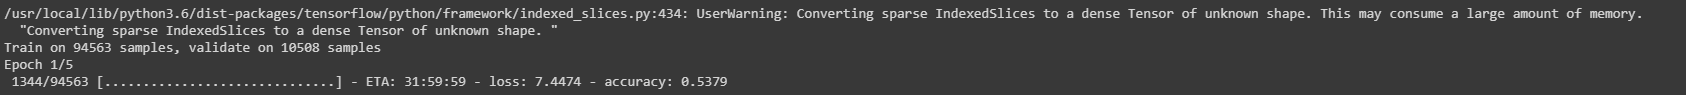

### Réalisation des epochs
Retour(s) attendu(s): Entrainements de X epochs avec modification des paramètres afin de mesurer notre précision.

Vu la puissance de nos machines nous avons décidé de partir dans un premier temps sur peu d'itération afin de voir si nous n'avions pas un modèle sur-entrainé.

In [8]:
model = Sequential(
    [
        keras.layers.Dense(512, input_shape=(max_words,), activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(2, activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

### Découpage du jeu de données pour effectuer la cross-validation
Retour(s) attendu(s): Pour éviter l'Overfitting de notre modèle nous l'arretons manuellement

Malgré plusieurs essais, notre modèle overfit trop au bout d'un moment d'exécution. Une des manières pour éviter cela serait l'utilisation des DropOut, par manque de temps nous avons décidé de laisser comme tel et d'étudier le cas DropOut dans un prochain projet.


### Sauvegarde du fichier afin de tester le modèle sur un autre jeu
Retour(s) attendu(s): Sauvegarde du modèle

Nous avons ajouté cette fonction afin de pouvoir tester rapidement notre modèle sur d'autres parties du jeu de données que nous avons utilisé

In [9]:
n_split = 10
test = KFold(n_split)
for train_index, test_index in KFold(n_split).split(train_x, train_y):
    x_train, x_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]
 
    history = model.fit(
        x_train,
        y_train,
        batch_size=32,
        epochs=4,
        verbose=1,
        validation_split=0.1,
        shuffle=True,
    )
    
    
#Sauvegarde du modèle afin de le retester par la suite
    model_json = model.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)

    model.save_weights('modelVF.h5')
    
    history_dict = history.history
    acc = history_dict["accuracy"]
    print(acc)
    if acc[-1] >= 0.93:
        break


Train on 16880 samples, validate on 1876 samples
Epoch 1/4
16880/16880 [==============================] - 10s 608us/step - loss: 0.5617 - accuracy: 0.7143 - val_loss: 0.4053 - val_accuracy: 0.8124
Epoch 2/4
16880/16880 [==============================] - 10s 566us/step - loss: 0.3569 - accuracy: 0.8457 - val_loss: 0.3179 - val_accuracy: 0.8561
Epoch 3/4
16880/16880 [==============================] - 9s 560us/step - loss: 0.2437 - accuracy: 0.9005 - val_loss: 0.3499 - val_accuracy: 0.8449
Epoch 4/4
16880/16880 [==============================] - 10s 566us/step - loss: 0.1459 - accuracy: 0.9447 - val_loss: 0.7191 - val_accuracy: 0.7415
[0.7143365, 0.8457346, 0.9005332, 0.94466823]


### Tokénisation et Récupération de notre dictionnaire sauvegardé

In [10]:
tokenizer = Tokenizer(num_words=10000)
labels = ['negative', 'positive']

with open('dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

### Vérification que tous les mots du document sont dans le dictionnaire

In [11]:
def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])
        else:
            print("'%s' not in training corpus; ignoring." %(word))
    return wordIndices

### Récupération du modèle

In [12]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# recréation du model
model = model_from_json(loaded_model_json)

# ainsi que les poids associés durant l'entrainement
model.load_weights('model.h5')

### Evaluation des phrases
Retour(s) attendu(s): Sentiment Positif/Negatif; Précision en %

Pour étudier les mots et vérifié le bon fonctionnement de notre modèle, il faut l'entrer dans la fonction ci-dessous.

In [13]:
#evalSentence = str(input('Saisir une phrase/mot à évaluer, ou Entrée # Modélisation et entrainement
### Première itération pour quitter : ')) 
evalSentence = "I am not happy."
if len(evalSentence) != 0:
    
    # Formatage
    testArr = convert_text_to_index_array(evalSentence)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    
    # Prediction
    pred = model.predict(input)
    print("%s sentiment; %f%% confidence" % (labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))

positive sentiment; 73.300797% confidence


#### Discussion du résultat :
Je ne suis pas content devrait être qualifié comme sentiment négatif mais ci-dessus il est qualifié de positif. Pour corriger ce soucis de compréhension qui est quand même noté à 73%, nous pourrions utiliser l'Embedding.

Ci-dessous, l'avis négatif est bien détecté avec le mot "mad"

In [14]:
#evalSentence = str(input('Saisir une phrase/mot à évaluer, ou Entrée # Modélisation et entrainement
### Première itération pour quitter : ')) 
evalSentence = "I am mad to see you today."
if len(evalSentence) != 0:
    
    # Formatage
    testArr = convert_text_to_index_array(evalSentence)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    
    # Prediction
    pred = model.predict(input)
    print("%s sentiment; %f%% confidence" % (labels[np.argmax(pred)], pred[0][np.argmax(pred)] * 100))

negative sentiment; 99.997139% confidence


# Annexes

### Test réalisés avec différentes achitectures
Embedding + LSTM

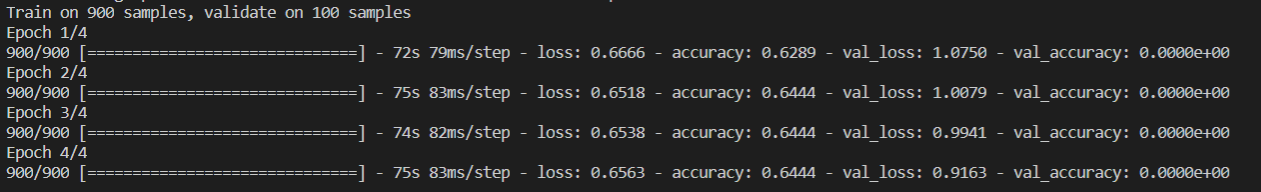
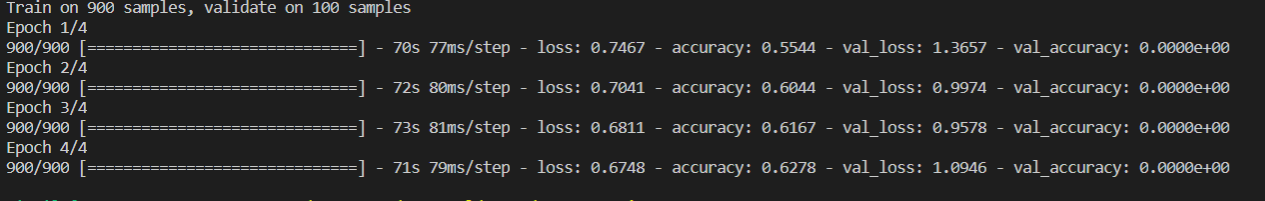
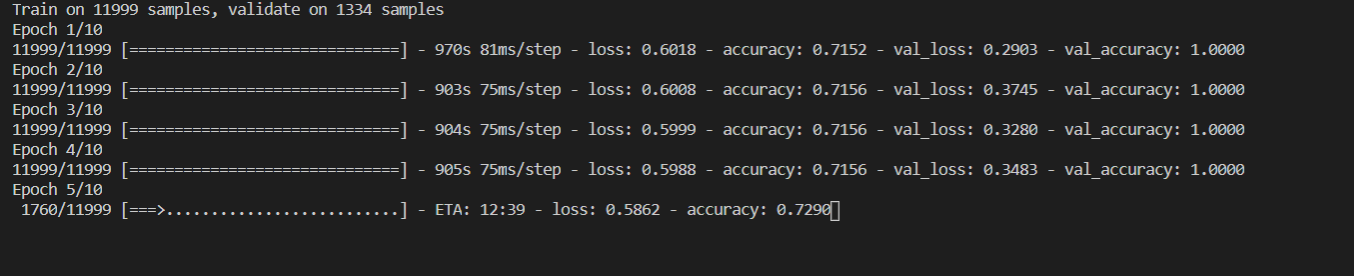